### Bayesian Quest Object Detection Notebook 

We will be covering the following processes when we are building the object detector from the scratch

**1. Build the train and test sets from the annotated images using HOG  feature extraction techniques**

**2. Save the features and labels in hdf5 format**

**3. Build a classifier for detecting potholes using SVM classifier**

**4. Introduction to image pyramids and sliding window techniques to predict bounding boxes for potholes during inference process**

**5. Optimise the bounding boxes using Non Maxima suppression.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import pandas as pd
import io
import cv2
from skimage import feature
import skimage
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.svm import SVC
import numpy as np
import argparse
import pickle
import matplotlib.pyplot as plt
from random import sample
%matplotlib inline

In [ ]:
basePath = '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/'

In [ ]:
# Positive Images
path = basePath + 'data'
allFiles = glob.glob(path + '/*.jpeg')
print(len(allFiles))
allFiles

19


['/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole1.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole2.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole3.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole4.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole5.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole6.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole7.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole8.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole9.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole10.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/pothole11.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-Obj

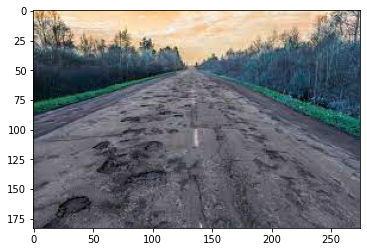

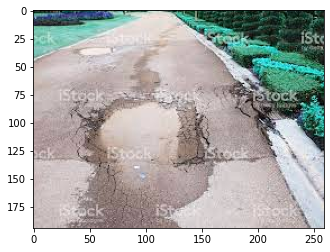

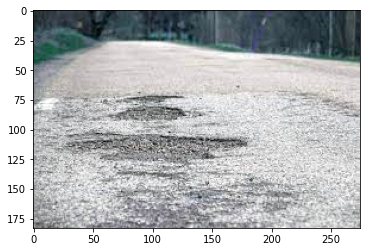

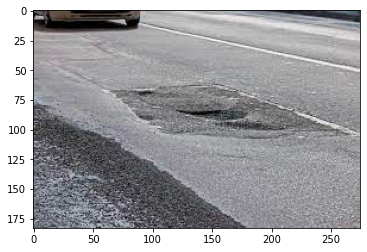

In [ ]:
for imgPath in allFiles[:4]:
    img = cv2.imread(imgPath)
    plt.imshow(img)
    plt.show()
    

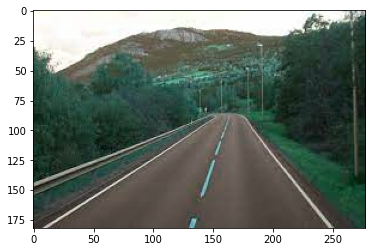

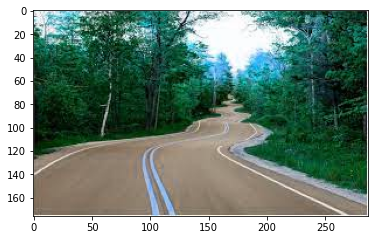

In [ ]:
# Negative images
path = basePath +  'data/Annotated'
roadFiles = glob.glob(path + '/*.jpeg')
for imgPath in roadFiles[:2]:
    img = cv2.imread(imgPath)
    plt.imshow(img)
    plt.show()

#### Extracting pothole data from CSV file

In [ ]:
# Reading the csv file
pothole_df = pd.read_csv(basePath+'pothole_df.csv')
pothole_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pothole1.jpeg,275,183,pothole,64,78,130,107
1,pothole1.jpeg,275,183,pothole,44,105,131,154
2,pothole1.jpeg,275,183,pothole,12,151,59,177
3,pothole1.jpeg,275,183,vegetation,163,33,254,58
4,pothole1.jpeg,275,183,pothole,115,54,142,74
...,...,...,...,...,...,...,...,...
60,pothole6.jpeg,275,183,vegetation,195,2,274,37
61,pothole6.jpeg,275,183,vegetation,10,5,82,26
62,pothole7.jpeg,259,194,pothole,75,50,214,149
63,pothole8.jpeg,262,192,pothole,56,59,196,135


In [ ]:
# Find the mean of the x dim and y dimensions of the pothole class
xdim = np.mean(pothole_df[pothole_df['class']=='pothole']['xmax'] - pothole_df[pothole_df['class']=='pothole']['xmin'])
ydim = np.mean(pothole_df[pothole_df['class']=='pothole']['ymax'] - pothole_df[pothole_df['class']=='pothole']['ymin'])
print(xdim,ydim)

89.6774193548387 48.83870967741935


In [ ]:
# We will take the windows dimension as these dimensions rounded off
winDim = [80,40]

In [ ]:
# Defining the hog structure
def hogFeatures(image,orientations,pixelsPerCell,cellsPerBlock,normalize=True):
    # Extracting the hog features from the image
    feat = feature.hog(image, orientations=orientations, pixels_per_cell=pixelsPerCell,cells_per_block = cellsPerBlock, transform_sqrt = normalize, block_norm="L1")
    feat[feat < 0] = 0
    return feat

In [ ]:
# Defining the function for image augmentation
def imgAug(roi,ht,wd,extensive=True):
    # Initialise the empty list to store images
    rois  = []
    # resize the ROI to the desired size
    roi = cv2.resize(roi, (ht,wd), interpolation=cv2.INTER_AREA)
    # Append the different images
    rois.append(roi)
    # Augment the image by flipping both horizontally and vertically
    rois.append(cv2.flip(roi, 1))
    if extensive:        
        rois.append(cv2.flip(roi, 0))
        rois.append(cv2.rotate(roi, cv2.ROTATE_90_CLOCKWISE))
        rois.append(cv2.rotate(roi, cv2.ROTATE_90_COUNTERCLOCKWISE))

        # Rotate to other angles
        for rot in [15,45,60,75,85]:
            # Get the rotation matrix
            rotMatrix = cv2.getRotationMatrix2D((ht/2,wd/2),rot,1)
            # ROtate the matrix using the rotation matrix
            rois.append(cv2.warpAffine(roi,rotMatrix,(ht,wd))) 
        
    return rois

In [ ]:
# Functions to extract the bounding boxes and the hog features
def roiExtractor(row,path):
    img = cv2.imread(path + row['filename'])
    #print(img.shape)
    # Get the bounding box elements
    bb = [int(row['xmin']),int(row['ymin']),int(row['xmax']),int(row['ymax'])]
    # Crop the image
    roi = img[bb[1]:bb[3], bb[0]:bb[2]]
    # Get the list of augmented images
    rois = imgAug(roi,80,40)
    return rois

def featExtractor(rois,data,labels):
    for roi in rois:
        # Extract hog features
        feat = hogFeatures(roi,orientations,pixelsPerCell,cellsPerBlock,normalize=True)
        # Append data and labels
        data.append(feat)
        labels.append(int(1))        
    return data,labels

In [ ]:
# let us now read the excel sheet and then extract the pothole patches from the data
path = basePath + 'data/'
# Parameters for extracting HOG features
orientations=12
pixelsPerCell=(4, 4)
cellsPerBlock=(2, 2)
# Empty lists to store data and labels
data = []
labels = []
# Looping through the excel sheet rows
for idx, row in pothole_df.iterrows():
    if row['class'] == 'pothole':
        rois = roiExtractor(row,path)
        data,labels = featExtractor(rois,data,labels)

In [ ]:
len(labels)

310

In [ ]:
# Listing all the negative examples
path = basePath +'data/Annotated'
roadFiles = glob.glob(path + '/*.jpeg')
roadFiles

['/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road1.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road2.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road3.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road4.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road5.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road6.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road7.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road8.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road9.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/Annotated/road10.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data

In [ ]:
# Looping through the files
for row in roadFiles:
    # Read the image
    img = cv2.imread(row)
    # Extract patches
    patches = extract_patches_2d(img,(80,40),max_patches=10)
    # For each patch do the augmentation
    for patch in patches:        
        # Get the list of augmented images
        rois = imgAug(patch,80,40,False)
        # Extract the features using HOG        
        for roi in rois:
            feat = hogFeatures(roi,orientations,pixelsPerCell,cellsPerBlock,normalize=True)
            data.append(feat)
            labels.append(int(-1))

In [ ]:
len(labels)

730

In [ ]:
import h5py
import numpy as np
# Define the output path
outputPath = basePath+'data/pothole_features_all.hdf5'

In [ ]:
# Create the database and write method
db = h5py.File(outputPath, "w")
dataset = db.create_dataset('pothole_features_all', (len(data), len(data[0]) + 1), dtype="float")
dataset[0:len(data)] = np.c_[labels, data]
db.close()

In [ ]:
# Read the h5py file
db = h5py.File(outputPath)
list(db.keys())

['pothole_features_all']

In [ ]:
# Shape of the data
db["pothole_features_all"].shape

(730, 8209)